<a href="https://colab.research.google.com/github/alexfc14/fancy-neural-networks/blob/master/Cross_Encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Cross-Encoder

This notebook contains an original proposal for generating class crossings between pairs of samples from a classification problem while preserving the rest of information, in the sense of autoencoder reconstruction.

Here is a sample result from the MNIST dataset where 28x28 images are encoded in a 16 component vector. Rows 1 and 3 are the original images, while 2 and 4 are the crossings, drawing the number of one original image in the "style" of the other.

<div>
<img src="https://drive.google.com/uc?id=1rVsAy2x2-b6cGSduPKqRp-dNlEH2lbAn" height="500"; align="right"/>
</div>



## Introduction

We are all familiar with the autoencoder architecture and how it can help compress the features of data: samples compressed through bottleneck layers, decompressed, and the reconstruction loss is minimized.
<div>
<img src="https://drive.google.com/uc?id=1aiUdPy2oQXsuOheMIJ7li2Qz9N8lN4j3" height="500"; align="right"/>
</div>

Sometimes, its use is extended to classification from such feature space, adding a classification loss to the overall loss.
<div>
<img src="https://drive.google.com/uc?id=1Np-3-uhIqowfHneLBR7HWNHWK35pFuFu" height="500"; align="right"/>
</div>

It helps the reconstruction block to reapply the encoding and classifier to the reconstruction, as it brings it closer to "normal" instances of the class. Later we will use this technique for a specific purpose.
<div>
<img src="https://drive.google.com/uc?id=1_MQuEsFNlGblROSmAusX4oHUp2Zw5HDw" height="500"; align="right"/>
</div>

Consider the case of insect image classification of bees vs ants.

We could say that a sample, for instance an image with a bee, contains features that are **relevant** to classification, in that they contain information related to bees, and others which are just **contextual**, like grass and background elements, illumination, etc... if they are interchangeable between classes (note that if we only provide images of ants on sand and bees on grass, this would not be the case).

From those relevant, some are **discriminative** in that they help the classifier tell that it's a bee and not and ant, and some others are **descriptive** in that they just describe in which particular ways this instance is a bee, like subspecies, the pose of wings...so they are context, but specific to the class.

Descriptive features could be used for further subclass classification, but in our problem they only help in the reconstruction task. For our purposes, we will dismiss them as contextual, hoping that they are interchangeable between classes by choosing the dataset appropriately.

In this setting, we wish to make an encoder that compresses samples into a space consisting of context and a class label, and a decoder that is able to reconstruct the original sample from that space, of course. In other words, we want one of the compressed features to be the class label, although we will actually use a fully connected classifying block to extract the class from the compressed space, and another one to extract context.

<div>
<img src="https://drive.google.com/uc?id=1ToWIf6jLlRLxBV7tlbZGz2tquAWjq_F5" height="500"; align="right"/>
</div>

Ultimately, we want to be able to **exchange classes and contexts** to generate plausible samples of class transfer and check that information is distilled. For this, we need **absence of class information in the context features, and absence of context information in the decoder layers**. Note that this is usually what happens with autoencoders, they learn to reconstruct by *memorizing* typical patterns of the specific dataset instead of reading the compressed space.

For this, I propose to introduce a third loss in the problem that accounts for the **mixing of information**, the *mix loss*. With randomly chosen pairs of samples, we exchange class and context and apply an "autodecoder". That is, reuse the decoder to decompress the context of each image and the class of the other into a fake image, reapply the encoder, and compare the resulting context and predicted class.

<div>
<img src="https://drive.google.com/uc?id=1mReZeYlNT4RTgU16cc7bwd1ev3MFwKiy" height="600"; align="center"/>
</div>

Quite a trick, right? 
- If the reconstruction of context is being made from class label and decoder memorization, the resulting context will be off.
- If the context carries class information, the resulting predicted class will not update.

## Code Example

Let us take the [mnist](https://keras.io/api/datasets/mnist/) number digit classification dataset from the keras api as a demo example.

In [ ]:
from keras.datasets import mnist
import numpy as np
import pandas as pd

def load_data():
  (x_train, y_train), (x_test, y_test) = mnist.load_data()
  
  x_train = x_train.astype('float32') / 255.
  x_test = x_test.astype('float32') / 255.
  x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
  x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

  return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = load_data()

11493376/11490434 [==============================] - 0s 0us/step


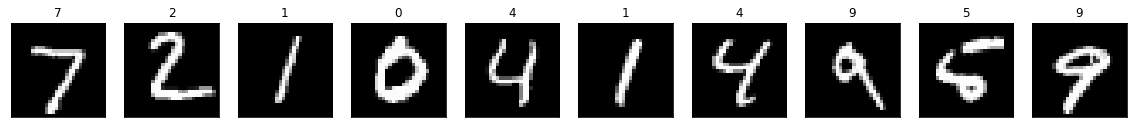

In [ ]:
import matplotlib.pyplot as plt

def plot_samples(x,y):
  plt.figure(figsize=(20, 2))
  for i, (xi, yi) in enumerate(zip(x,y)):
    ax = plt.subplot(1, len(x), i+1)
    plt.imshow(xi.reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(f'{yi}')
  plt.show()

plot_samples(x_test[:10],y_test[:10])

### Autoencoder:

encoder & decoder models



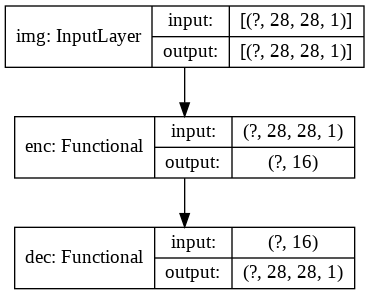

In [ ]:
import keras
from keras import layers

encoder_input = keras.Input(shape=(28, 28, 1), name="original_img")
x = layers.Conv2D(16, 3, activation="relu")(encoder_input)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.Conv2D(16, 3, activation="relu")(x)
encoder_output = layers.GlobalMaxPooling2D()(x)
encoder = keras.Model(encoder_input, encoder_output, name="enc")
# encoder.summary()

decoder_input = keras.Input(shape=(16,), name="encoded_img")
x = layers.Reshape((4, 4, 1))(decoder_input)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu")(x)
x = layers.UpSampling2D(3)(x)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
decoder_output = layers.Conv2DTranspose(1, 3, activation="relu")(x)
decoder = keras.Model(decoder_input, decoder_output, name="dec")
# decoder.summary()

autoencoder_input = keras.Input(shape=(28, 28, 1), name="img")
encoded_img = encoder(autoencoder_input)
decoded_img = decoder(encoded_img)
autoencoder = keras.Model(autoencoder_input, decoded_img, name="autoencoder")
autoencoder.compile(optimizer='adamax', loss='binary_crossentropy')
# autoencoder.summary()
keras.utils.plot_model(autoencoder, "autoencoder.png", show_shapes=True)

In [ ]:
autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                verbose=2,
                validation_data=(x_test, x_test),
                # callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)]
                )

In [ ]:
pd.DataFrame(model.history.history).plot(ylim=(0,1))

### Autoencoder Classifier

Reuse trained layers of the autoencoder, only define new ones for the classifier, isn't that great?

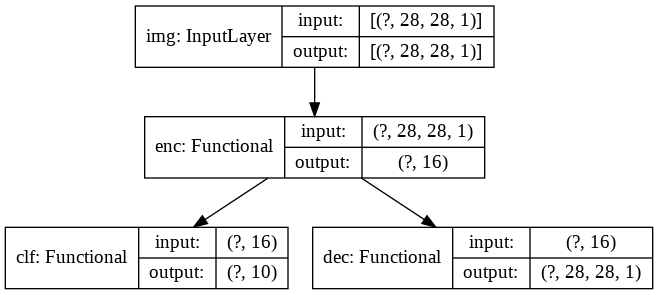

In [ ]:
classifier_input = keras.Input(shape=(16,), name="encoded_img_clf_input")
x = layers.Dense(12,activation='relu')(classifier_input)
x = layers.Dense(10,activation='relu')(x)
classifier_output = layers.Dense(10,activation='softmax')(x)
classifier = keras.Model(classifier_input, classifier_output, name="clf")
# classifier.summary()

autoencoder_input = keras.Input(shape=(28, 28, 1), name="img")
encoded_img = encoder(autoencoder_input)
decoded_img = decoder(encoded_img)
class_pred = classifier(encoded_img)
model = keras.Model(autoencoder_input, {'class':class_pred, 'rec':decoded_img}, name="autoencoder_classifier")
model.compile(optimizer='adamax', loss={'class':'sparse_categorical_crossentropy','rec':'binary_crossentropy'},metrics={'class':'accuracy'})
# model.summary()
keras.utils.plot_model(model, "autoencoder_classifier.png", show_shapes=True)

In [ ]:
model.fit(x=x_train,y={'class':y_train,'rec':x_train},
                epochs=100,
                batch_size=128,
                shuffle=True,
                verbose=2,
                validation_data=(x_test, {'class':y_test,'rec':x_test}),
          )

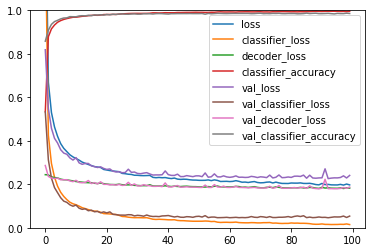

In [ ]:
ax=pd.DataFrame(model.history.history).plot(ylim=(0,1))

### Autoencoder Classifier and Context Extractor

encoder & classifier & context extractor

& decoder from context & class

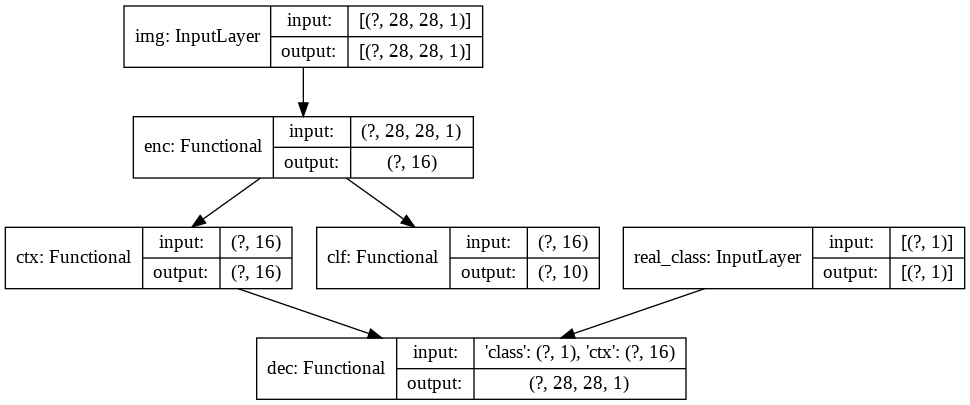

In [ ]:
import keras
from keras import layers

#use an embedding the same size as the context to later concatenate them
real_class = keras.Input(shape=(1,), name="real_class")
number_embedding = keras.layers.Embedding(input_dim=10,input_length=1,output_dim=16, name='number_embedding')(real_class)
number_img = layers.Reshape((4, 4, 1))(number_embedding)

context_input = keras.Input(shape=(16,), name="context_input")
x = layers.Dense(16,activation='relu')(context_input)
x = layers.Dense(16,activation='relu')(x)
context_extractor_output = layers.Dense(16,activation='sigmoid')(x)
context_extractor = keras.Model(context_input, context_extractor_output, name="ctx")

context_output = keras.Input(shape=(16,), name="context_output")
encoded_img = layers.Reshape((4, 4, 1),name='encoded_img')(context_output)
x = layers.concatenate([encoded_img, number_img],axis=-1)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu")(x)
x = layers.UpSampling2D(3)(x)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
decoder_output = layers.Conv2DTranspose(1, 3, activation="relu")(x)
decoder = keras.Model({'class':real_class,'ctx':context_output}, decoder_output, name="dec")
# decoder.summary()

x = keras.Input(shape=(28, 28, 1), name="img")
y = keras.Input(shape=(1,), name="real_class")
xe = encoder(x)
xc = context_extractor(xe)
yp = classifier(xe)
xd = decoder({'class':y,'ctx':xc})
model = keras.Model({'img':x,'class':y}, {'class':yp, 'dec':xd}, name="autoencoder_classifier")
model.compile(optimizer='adam', loss={'class':'sparse_categorical_crossentropy','dec':'binary_crossentropy'},metrics={'class':'accuracy'})
# model.summary()
keras.utils.plot_model(model, "autoencoder_classifier.png", show_shapes=True)

In [ ]:
model.fit(x={'img':x_train, 'class':y_train},y={'dec':x_train, 'class':y_train},
          validation_data=({'img':x_test, 'class':y_test}, {'dec':x_test, 'class':y_test}),
          epochs=100,batch_size=128, shuffle=True, verbose=2,
          )

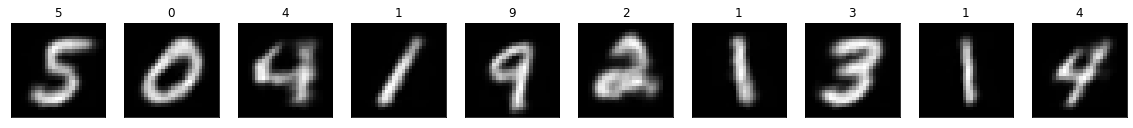

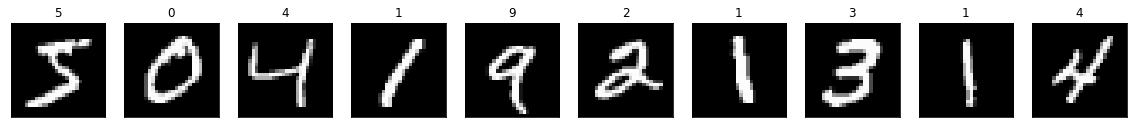

In [ ]:
res = model.predict({'img':x_train[:10], 'class':y_train[:10]})
plot_samples(res['dec'], res['class'].argmax(axis=1))
plot_samples(x_train[:10], y_train[:10])

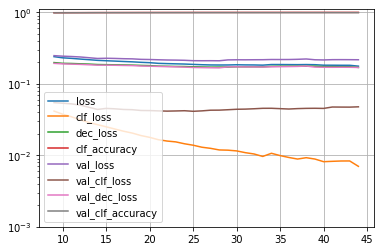

In [ ]:
pd.DataFrame(model.history.history).rolling(10).mean().plot(ylim=(0.001,1.1),logy=True,grid=True)

In [ ]:
w=model.get_weights()
model.save_weights('weights.hdf5')

### Autoencoder Reclassifier

encoder & classifier

decoder from encoded & class

reencode & reclassifier

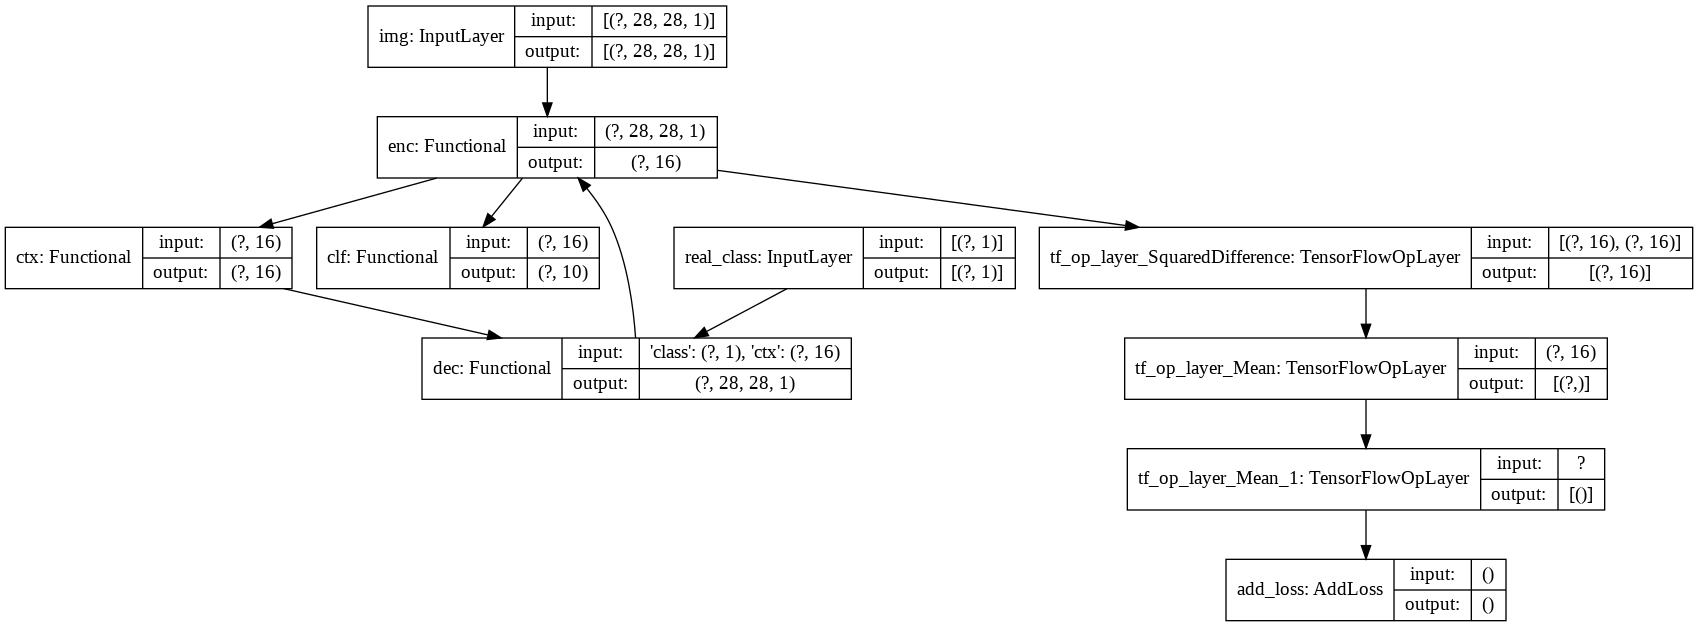

In [ ]:
x = keras.Input(shape=(28, 28, 1), name="img")
y = keras.Input(shape=(1,), name="real_class")
xe = encoder(x)
xc = context_extractor(xe)
yp = classifier(xe)
xd = decoder({'class':y,'ctx':xc})

xre = encoder(xd)
yrp = classifier(xre)

model = keras.Model(inputs={'img':x,'class':y}, outputs={'class':yp, 'dec':xd, 'reclass':yrp}, name="autoencoder_classifier")

reenc_loss = keras.backend.mean(keras.losses.mse(xe, xre))
model.add_loss(reenc_loss)

model.compile(optimizer='adam', 
              loss={'class':'sparse_categorical_crossentropy', 'dec':'binary_crossentropy', 'reclass':'sparse_categorical_crossentropy'},
              metrics={'class':'accuracy', 'reclass':'accuracy'})
keras.utils.plot_model(model, "autoencoder_classifier.png", show_shapes=True)

In [ ]:
model.fit(x={'img':x_train, 'class':y_train},
          y={'class':y_train, 'dec':x_train, 'reclass': y_train},
          validation_data=({'img':x_test, 'class':y_test}, 
                           {'dec':x_test, 'class':y_test, 'reclass': y_test}),
          epochs=100,batch_size=128, shuffle=True, verbose=2,
          )

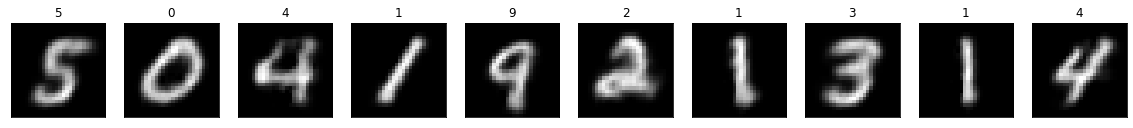

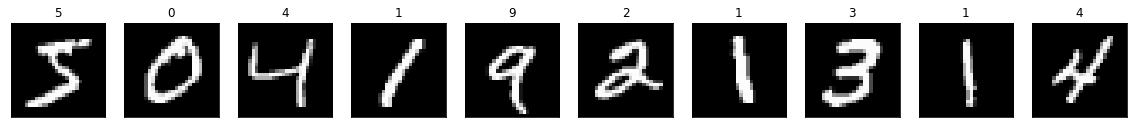

In [ ]:
res = model.predict({'img':x_train[:10], 'class':y_train[:10]})
plot_samples(res['dec'], res['class'].argmax(axis=1))
plot_samples(x_train[:10], y_train[:10])

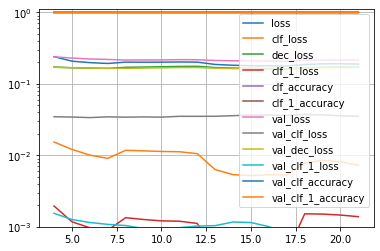

In [ ]:
pd.DataFrame(model.history.history).rolling(5).mean().plot(ylim=(0.001,1.1),logy=True,grid=True)

### Cross-Encoder

Make the crossing of context and class and enforce recovery of each.

In [ ]:
def make_pairs(X,y):
  p=np.random.permutation(len(X))
  return {'img1':X, 'img2':X[p], 'class1':y, 'class2':y[p]}

pairs_train=make_pairs(x_train, y_train)
pairs_test=make_pairs(x_test, y_test)

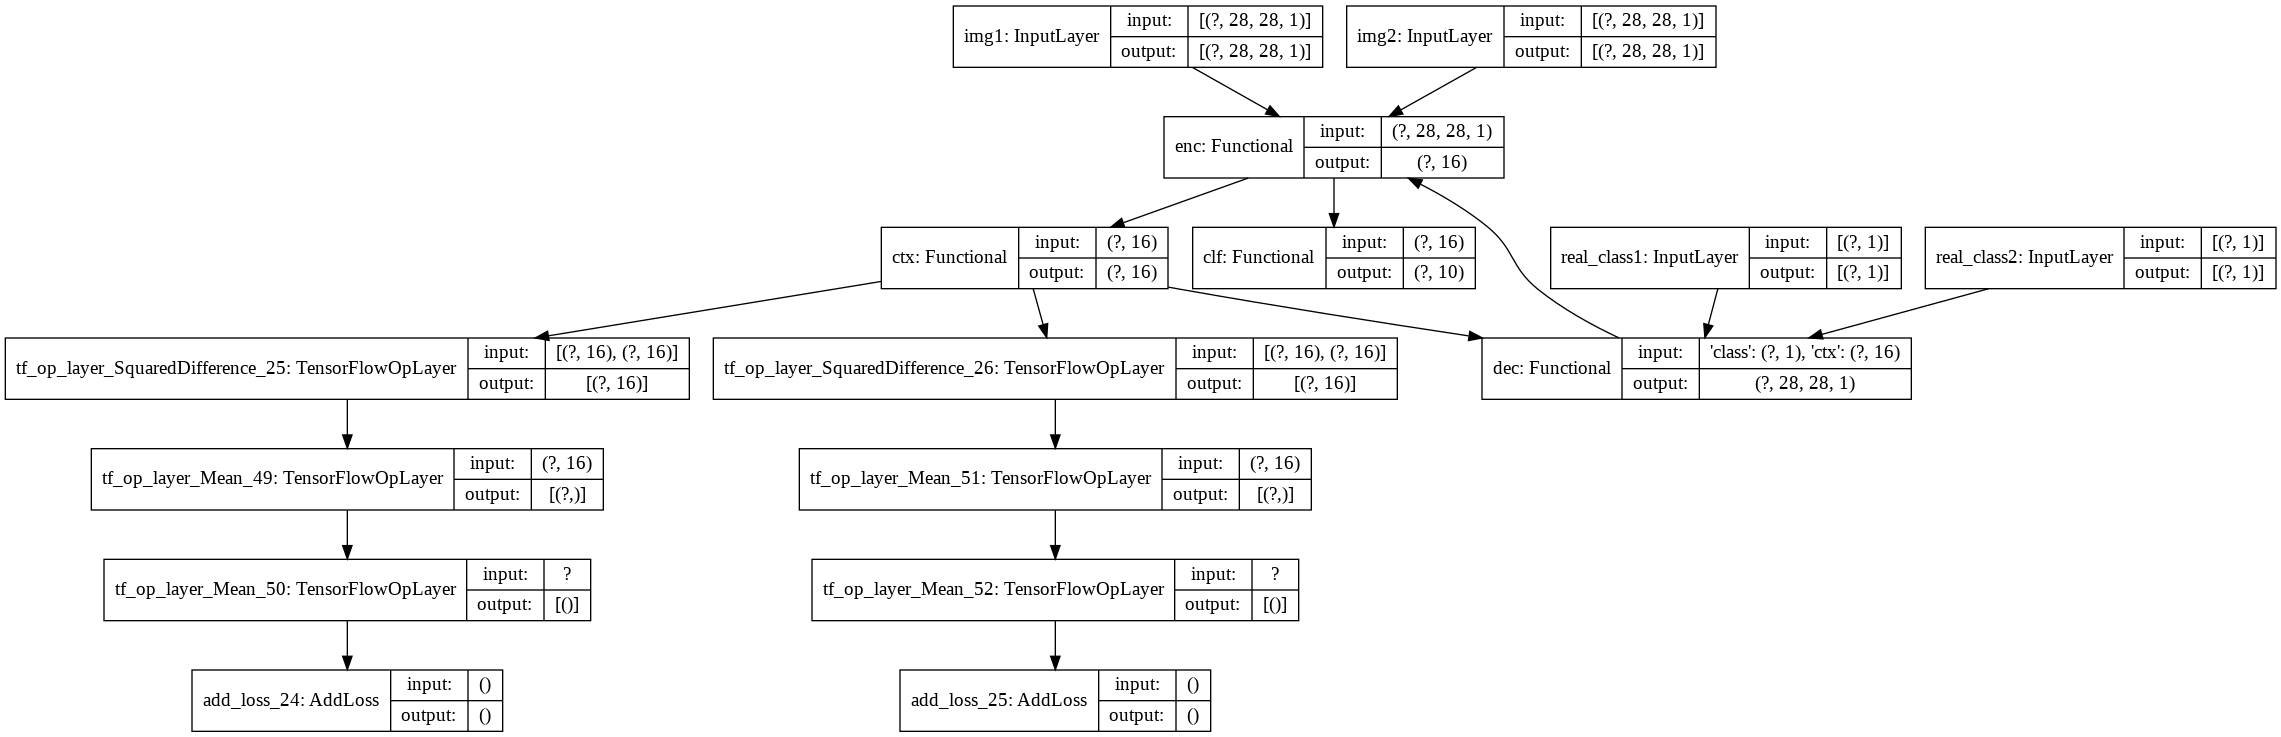

In [ ]:
x1 = keras.Input(shape=(28, 28, 1), name="img1")
y1 = keras.Input(shape=(1,), name="real_class1")
xe1 = encoder(x1)
yp1 = classifier(xe1)
xc1 = context_extractor(xe1)
xd1 = decoder({'ctx':xc1,'class':y1})

x2 = keras.Input(shape=(28, 28, 1), name="img2")
y2 = keras.Input(shape=(1,), name="real_class2")
xe2 = encoder(x2)
yp2 = classifier(xe2)
xc2 = context_extractor(xe2)
xd2 = decoder({'ctx':xc2, 'class':y2})

#decode with crossed classes
xd12 = decoder({'ctx':xc1, 'class':y2})
xre12 = encoder(xd12)
xc12 = context_extractor(xre12)
yrp12 = classifier(xre12)

xd21 = decoder({'ctx':xc2, 'class':y1})
xre21 = encoder(xd21)
xc21 = context_extractor(xre21)
yrp21 = classifier(xre21)

model = keras.Model(inputs={'img1':x1,'class1':y1,
                            'img2':x2,'class2':y2},
                    outputs={'class1':yp1, 'dec1':xd1, 'reclass1':yrp12, 'dec12':xd12,
                             'class2':yp2, 'dec2':xd2, 'reclass2':yrp21, 'dec21':xd21},
                    name="autoencoder_classifier")

#enforce context recovery despite having crossed the class
reenc_loss1 = keras.backend.mean(keras.losses.mse(xc1, xc12))
model.add_loss(reenc_loss1)
reenc_loss2 = keras.backend.mean(keras.losses.mse(xc2, xc21))
model.add_loss(reenc_loss2)

model.compile(optimizer=keras.optimizers.Adam(lr=0.0001), 
              loss={'class1':'sparse_categorical_crossentropy', 'dec1':'binary_crossentropy', 'reclass1':'sparse_categorical_crossentropy',
                    'class2':'sparse_categorical_crossentropy', 'dec2':'binary_crossentropy', 'reclass2':'sparse_categorical_crossentropy'},
              metrics={'class1':'accuracy', 'reclass1':'accuracy',
                       'class2':'accuracy', 'reclass2':'accuracy'})

keras.utils.plot_model(model, "autoencoder_classifier.png", show_shapes=True)

Ignore the "tf_..." layers, which come from the internal loss function of context recovery.

In [ ]:
model.fit(x=pairs_train,
          y={'class1':pairs_train['class1'], 'dec1':pairs_train['img1'], 'reclass1':pairs_train['class2'],
             'class2':pairs_train['class2'], 'dec2':pairs_train['img2'], 'reclass2':pairs_train['class1']},
          validation_data=(pairs_test, 
                           {'class1':pairs_test['class1'], 'dec1':pairs_test['img1'], 'reclass1':pairs_test['class2'],
                            'class2':pairs_test['class2'], 'dec2':pairs_test['img2'], 'reclass2':pairs_test['class1']}),
          epochs=20,batch_size=128, shuffle=True, verbose=2,
          )

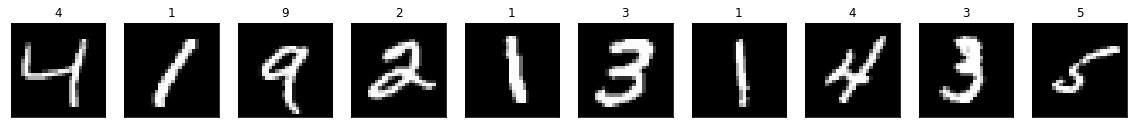

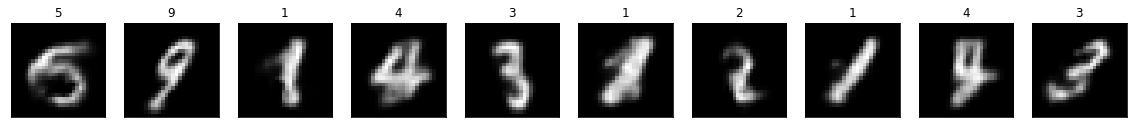

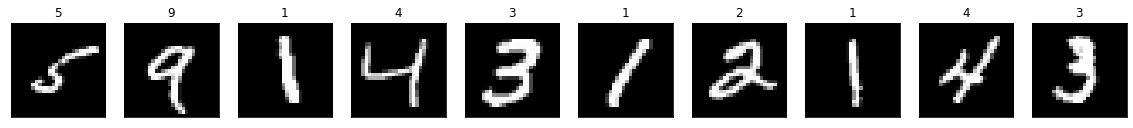

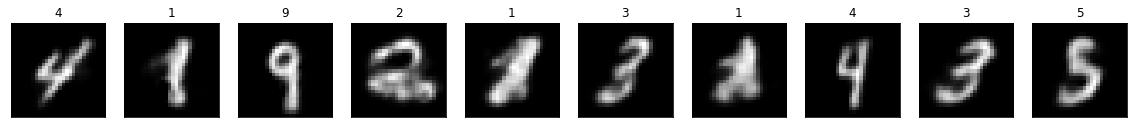

In [ ]:
first_pairs=make_pairs(x_train[2:12], y_train[2:12])
res = model.predict(first_pairs)

plot_samples(first_pairs['img1'], first_pairs['class1'])
# plot_samples(res['dec1'], res['class1'].argmax(axis=1))
plot_samples(res['dec12'], res['reclass1'].argmax(axis=1))
plot_samples(first_pairs['img2'], first_pairs['class2'])
# plot_samples(res['dec2'], res['class2'].argmax(axis=1))
plot_samples(res['dec21'], res['reclass2'].argmax(axis=1))

Rows 1 and 3 are the original pairs, and rows 2 and 4 are the context and class crossing. It works!
- the style (diagonal vs vertical, round vs straight,...) is preserved despite the digit is changed
- the digit get correctly classified despite it uses a different context